In [0]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6

In [0]:
# Imports
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from zipfile import ZipFile
import networkx as nx
import pandas as pd
import difflib
import operator
import math
import os
%matplotlib inline

In [0]:

# Import Country data
url_country = 'https://raw.githubusercontent.com/cpenalozag/colombia_gvc/master/data/Database_GVC_2018.csv'
countries = pd.read_csv(url_country, header=None)
countries = countries.rename(columns=countries.iloc[0])
countries = countries.drop(countries.index[0])
        
nodes = {}
 
# Fill node dictionary
for index, row in countries.iterrows():
    if index == 0 or row["DVX2015"]=='0': continue
    nodes[row[0].upper()]={"DVX2015": float(row["DVX2015"]), "VA_exp2015": float(row["VA_exp2015"]),"FVA2015": float(row["FVA2015"]),"GVC2015": float(row["GVC2015"]),"DVA2015": float(row["DVA2015"])}

# Import coordinate data
url_coordinates = 'https://raw.githubusercontent.com/cpenalozag/colombia_gvc/master/data/LonLat.csv'
coords = pd.read_csv(url_coordinates, sep=" ;", header=None, engine='python')

def similar(landstring, country):
  l = difflib.get_close_matches(landstring, country, 1)
  if not l: return []
  return l[0]


for index, row in coords.iterrows():
  name = similar(row[0].upper(), nodes)
  if not name: continue
  if name in nodes:
    nodes[name]["lat"]=(row[1])
    nodes[name]["lon"]=(row[2])
  
for n in [n for n in nodes if 'lat' not in nodes[n]]:
  del nodes[n]

# List of countries ordered by variable
l = [float(c) for c in countries['VA_exp2015']]
l.sort()

In [0]:
# Import Country to Sector data
url_country2sector = 'https://raw.githubusercontent.com/cpenalozag/colombia_gvc/master/data/country_to_sector/UNCTADGVC.2015.F_country_to_sector.txt'

country2sector = pd.read_csv(url_country2sector, sep="	", header=None)
country2sector.set_index(0, inplace=True)
 
country2sector.head(n=10)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,14800,14801,14802,14803,14804,14805,14806,14807,14808,14809,14810,14811,14812,14813,14814,14815,14816,14817,14818,14819,14820,14821,14822,14823,14824,14825,14826,14827,14828,14829,14830,14831,14832,14833,14834,14835,14836,14837,14838,14839
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NaN,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Albania,Albania,Albania,Albania,Albania,Albania,Albania,Albania,Albania,Albania,Albania,Albania,Albania,Albania,...,Zambia,Zambia,Zambia,Zambia,Zambia,Zambia,Zambia,Zambia,Zambia,Zambia,Zambia,Zambia,Zambia,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Zimbabwe,Statistical Discrepancies
NaN,AFG,AFG,AFG,AFG,AFG,AFG,AFG,AFG,AFG,AFG,AFG,AFG,AFG,AFG,AFG,AFG,AFG,AFG,AFG,AFG,AFG,AFG,AFG,AFG,AFG,AFG,ALB,ALB,ALB,ALB,ALB,ALB,ALB,ALB,ALB,ALB,ALB,ALB,ALB,ALB,...,ZMB,ZMB,ZMB,ZMB,ZMB,ZMB,ZMB,ZMB,ZMB,ZMB,ZMB,ZMB,ZMB,ZWE,ZWE,ZWE,ZWE,ZWE,ZWE,ZWE,ZWE,ZWE,ZWE,ZWE,ZWE,ZWE,ZWE,ZWE,ZWE,ZWE,ZWE,ZWE,ZWE,ZWE,ZWE,ZWE,ZWE,ZWE,ZWE,ROW
NaN,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,...,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries,Industries
NaN,Agriculture,Fishing,Mining and Quarrying,Food & Beverages,Textiles and Wearing Apparel,Wood and Paper,"Petroleum, Chemical and Non-Metallic Mineral P...",Metal Products,Electrical and Machinery,Transport Equipment,Other Manufacturing,Recycling,"Electricity, Gas and Water",Construction,Maintenance and Repair,Wholesale Trade,Retail Trade,Hotels and Restraurants,Transport,Post and Telecommunications,Finacial Intermediation and Business Activities,Public Administration,"Education, Health and Other Services",Private Households,Others,Re-export & Re-import,Agriculture,Fishing,Mining and Quarrying,Food & Beverages,Textiles and Wearing Apparel,Wood and Paper,"Petroleum, Chemical and Non-Metallic Mineral P...",Metal Products,Electrical and Machinery,Transport Equipment,Other Manufacturing,Recycling,"Electricity, Gas and Water",Construction,...,Construction,Maintenance and Repair,Wholesale Trade,Retail Trade,Hotels and Restraurants,Transport,Post and Telecommunications,Finacial Intermediation and Business Activities,Public Administration,"Education, Health and Other Services",Private Households,Others,Re-export & Re-import,Agriculture,Fishing,Mining and Quarrying,Food & Beverages,Textiles and Wearing Apparel,Wood and Paper,"Petroleum, Chemical and Non-Metallic Mineral P...",Metal Products,Electrical and Machinery,Transport Equipment,Other Manufacturing,Recycling,"Electricity, Gas and Water",Construction,Maintenance and Repair,Wholesale Trade,Retail Trade,Hotels and Restraurants,Transport,Post and Telecommunications,Finacial Intermediation and

In [0]:
country_names = [row for row in country2sector.index][4:]

industries = set([])

for i in range (1,int(len(country2sector.columns))):
  name = country2sector.loc[:,i][0]
  industry = country2sector.loc[:,i][3]
  
  if name == 'Colombia':
    industries.add(industry)

networks = {}

for i in industries:
  networks[i] = nx.DiGraph()
  for n in nodes:
    networks[i].add_node(n,**nodes[n])

In [0]:
edge_data = []

[country2sector.loc[country_names[0],1]]

for i in range (1,int(len(country2sector.columns))):
  name = country2sector.loc[:,i][0]
  industry = country2sector.loc[:,i][3]
  for c in country_names:
    edge = (name, c)
    value = float(country2sector.loc[c,i])
    if value != 0.0:
      edge_data.append([name,c,industry,value])   

In [0]:
for edge in edge_data:
  destination = edge[0].upper()
  origin = edge[1].upper()
  
  if edge[2] in networks and origin in nodes and destination in nodes:
    networks[edge[2]].add_edge(origin, destination, weight=edge[3])

  
zipObj = ZipFile('redes.zip', 'w')  

for i in industries:
  print('Cantidad arcos', i, networks[i].number_of_edges())
  
  # Export graphml file
  file_name = i.replace('/','')+'.graphml'
  nx.write_graphml(networks[i], file_name)
  zipObj.write(file_name)

zipObj.close()

In [0]:
networks['Education services'].nodes['COLOMBIA']

{'DVA2015': 28472240.0,
 'DVX2015': 7702419.0,
 'FVA2015': 2729238.0,
 'GVC2015': 10431660.0,
 'VA_exp2015': 31201480.0,
 'lat': 4.0,
 'lon': -72.0}

In [0]:
# Draw the network

def draw_network(G):

  fig = plt.figure(figsize=(16,11))


  m = Basemap(
          projection='merc',
          llcrnrlat=-58,urcrnrlat=75,
          llcrnrlon=-168,urcrnrlon=168,
          lat_ts=20,resolution='l')

  # Number of nodes with details
  num = 20

  mx, my = m([i for i in nx.get_node_attributes(G,'lon').values()], [i for i in nx.get_node_attributes(G,'lat').values()])
  pos = {}

  for index, key in enumerate(nodes):
    pos[key] = (mx[index], my[index])

  [g for g in G.nodes() if G.nodes[g]['VA_exp2015']>l[-num] ]


  nx.draw_networkx_nodes(G, pos, 
                         nodelist = [g for g in G.nodes() if G.nodes[g]['VA_exp2015']<=l[-num] ],
                         node_size = [math.sqrt(G.nodes[g]['VA_exp2015'])/27 for g in G.nodes() if G.nodes[g]['VA_exp2015']<=l[-num]],
                         node_color = 'grey', alpha = 0.8)

  nx.draw_networkx_nodes(G, pos, 
                         nodelist = [g for g in G.nodes() if G.nodes[g]['VA_exp2015']>l[-num] ], 
                         node_size = [math.sqrt(G.nodes[g]['VA_exp2015'])/27 for g in G.nodes() if G.nodes[g]['VA_exp2015']>l[-num]],
                         node_color = 'grey', alpha = 0.8)


  nx.draw_networkx_nodes(G, pos, 
                         nodelist = ["COLOMBIA"],
                         node_color = 'y', alpha = 1)

  nx.draw_networkx_labels(G, pos, font_size=8, font_color='w',
                              labels = {x:x for x in G.nodes() if G.nodes[x]['VA_exp2015']>l[-num]})
  
  nx.draw_networkx_labels(G, pos, font_size=14, font_color='w', font_weight='bold',
                             labels = {x:x for x in G.nodes() if x=="COLOMBIA"})

  nx.draw_networkx_edges(G.edge_subgraph(edges=[(u,v) for u,v,e in G.edges(data=True) if u == 'COLOMBIA' or v == 'COLOMBIA'])
                         , pos, edge_color='grey')

  m.drawcountries(color='white')
  m.bluemarble(scale=0.2)
  plt.tight_layout()

  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


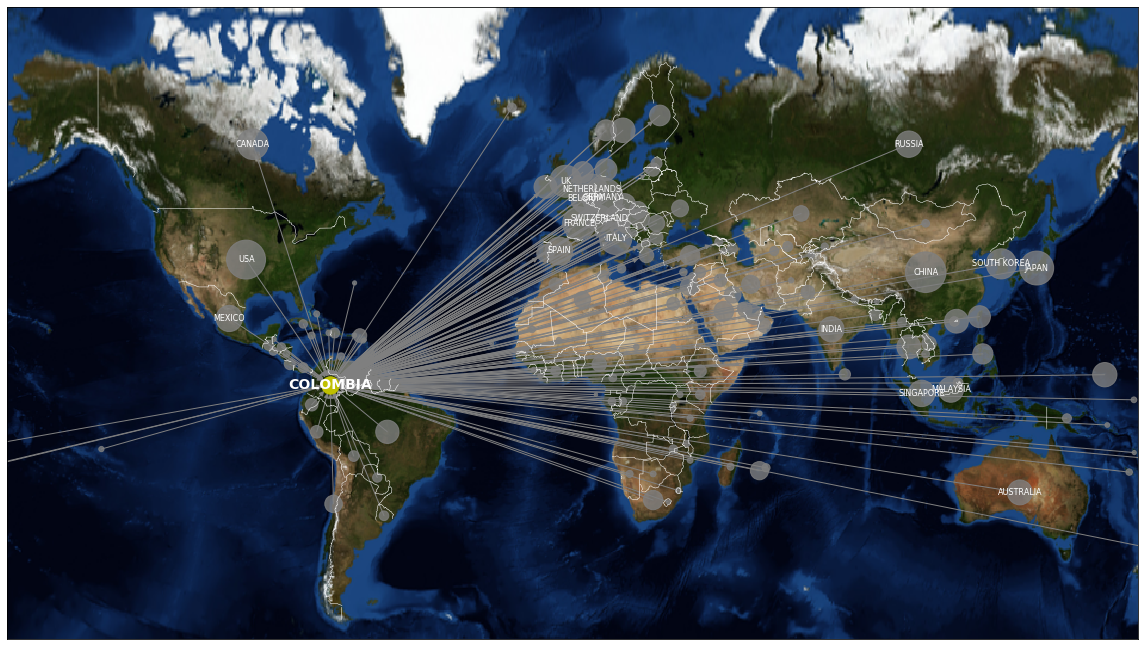

In [52]:
draw_network(networks['Education services'])

In [0]:
[networks['Recycling'].nodes[g] for g in networks['Recycling']]

KeyError: ignored